In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
audio_files_dir = '/content/gdrive/My Drive/UpworkNotebooks/Opera Files/'

!ls -ltra '{audio_files_dir}'/.

Mounted at /content/gdrive
ls: '/content/gdrive/My Drive/UpworkNotebooks/Opera Files//./Audios': No such file or directory
total 32
lrw------- 1 root root    0 May  1  2021 Audios -> /content/gdrive/.shortcut-targets-by-id/1DOvML8hO7v6XEq5-HQAQSvo7eKca7tSf/Audios
drwx------ 2 root root 4096 Sep 12 11:40 New_male_only_200_each
drwx------ 2 root root 4096 Sep 22 14:29 All_Data
drwx------ 2 root root 4096 Sep 22 14:40 Keras_Tuner_Logs
drwx------ 2 root root 4096 Sep 22 14:57 Documentation
drwx------ 2 root root 4096 Sep 22 15:02 Helper_Notebooks
drwx------ 2 root root 4096 Sep 22 15:03 Csv_Files
drwx------ 2 root root 4096 Sep 22 15:05 Main_Notebooks
drwx------ 2 root root 4096 Oct 27 13:51 CNN_Data


In [ ]:
!pip install -q librosa
!pip install -q tensorflow_io
!pip install -q pysoundfile

     |████████████████████████████████| 22.7 MB 1.5 MB/s 


In [ ]:
import os
import librosa

from IPython import display
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio

import time

%matplotlib inline

import urllib.request as urllib2 # For python3
import sklearn
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

In [ ]:
src_path = audio_files_dir + "All_Data/males_500_cleaner_zip/males_500_cleaner.zip"
dst_path = audio_files_dir + "All_Data/males_500_cleaner"
print(src_path)
print(dst_path)

/content/gdrive/My Drive/UpworkNotebooks/Opera Files/All_Data/males_500_cleaner_zip/males_500_cleaner.zip
/content/gdrive/My Drive/UpworkNotebooks/Opera Files/All_Data/males_500_cleaner


In [ ]:
!unzip '{src_path}' -d '{dst_path}'

Archive:  /content/gdrive/My Drive/UpworkNotebooks/Opera Files/All_Data/males_500_cleaner_zip/males_500_cleaner.zip
replace /content/gdrive/My Drive/UpworkNotebooks/Opera Files/All_Data/males_500_cleaner/males_500_cleaner/baritone/baritone_bassbaritones/Die_Meistersinger_von_N├╝rnberg_-__Wahn__(_Madness_)_тАУ_Glyndebourne-EdUR5Q2cCaQ_10.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/gdrive/My Drive/UpworkNotebooks/Opera Files/All_Data/males_500_cleaner/males_500_cleaner/baritone/baritone_bassbaritones/Die_Meistersinger_von_N├╝rnberg_-__Wahn__(_Madness_)_тАУ_Glyndebourne-EdUR5Q2cCaQ_10.wav  
  inflating: /content/gdrive/My Drive/UpworkNotebooks/Opera Files/All_Data/males_500_cleaner/males_500_cleaner/baritone/baritone_bassbaritones/Die_Meistersinger_von_N├╝rnberg_-__Wahn__(_Madness_)_тАУ_Glyndebourne-EdUR5Q2cCaQ_11.wav  
  inflating: /content/gdrive/My Drive/UpworkNotebooks/Opera Files/All_Data/males_500_cleaner/males_500_cleaner/baritone/baritone_bassbaritones/Die_M

In [ ]:
#####save file_paths and their respective subregisters in .csv file####
directory = audio_files_dir + "All_Data/males_500_cleaner/"
print(directory)
paths = [os.path.abspath(os.path.join(dirpath, file)) for dirpath,_,filenames in os.walk(directory) for file in filenames]
subregisters = [os.path.basename(os.path.normpath(dirpath)) for dirpath,_,filenames in os.walk(directory) for file in filenames]

data = pd.DataFrame()

data["path"] = paths
data["subregister"] = subregisters

classes_mapping = dict()
for num, subregister in enumerate(data["subregister"].unique()):
  classes_mapping[subregister]=num
class_id = data['subregister'].apply(lambda name: classes_mapping[name])
data = data.assign(Target=class_id)

print(data.head())

data.to_csv(audio_files_dir + "Csv_Files/males_500_cleaner_for_CNN.csv", index=False)


/content/gdrive/My Drive/UpworkNotebooks/Opera Files/All_Data/males_500_cleaner/
                                                path  ... Target
0  /content/gdrive/My Drive/UpworkNotebooks/Opera...  ...      0
1  /content/gdrive/My Drive/UpworkNotebooks/Opera...  ...      0
2  /content/gdrive/My Drive/UpworkNotebooks/Opera...  ...      0
3  /content/gdrive/My Drive/UpworkNotebooks/Opera...  ...      0
4  /content/gdrive/My Drive/UpworkNotebooks/Opera...  ...      0

[5 rows x 3 columns]


In [ ]:
data = pd.read_csv(audio_files_dir + "Csv_Files/males_500_cleaner_for_CNN.csv")

In [ ]:
print(len(data))

3889


In [ ]:
data['subregister'].unique()

array(['baritone_bassbaritones', 'baritone_dramatic', 'baritone_lyric',
       'bass_cantante', 'bass_dramatic', 'tenor_leggero', 'tenor_spinto',
       'tenor_lyric', 'tenor_dramatic'], dtype=object)

In [ ]:
def extract_features(file_name):
  audio, sample_rate = librosa.load(file_name) 
  mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
  mfccs_processed = np.mean(mfccs.T,axis=0)
  mfccs_processed = list(mfccs_processed)
  return mfccs_processed

mfcc_featuresdf = pd.DataFrame()
mfcc_featuresdf["mfccs"] = list(map(extract_features, data["path"]))
mfcc_featuresdf["class_label"] = data["Target"]

mfcc_featuresdf["mfccs"]
mfcc_featuresdf.to_csv(audio_files_dir + "Csv_Files/males_500_cleaner_mfccs.csv", index=False)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")

In [ ]:
mfcc_featuresdf["class_label"].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
data = pd.read_csv(audio_files_dir + "Csv_Files/males_500_cleaner_mfccs.csv")
data.head()

,mfccs,class_label
0,"[-476.93088, 145.94034, -98.85765, 27.525955, ...",0
1,"[-600.0592, 153.83911, -67.991844, 0.10335349,...",0
2,"[-482.42645, 151.72128, -85.762886, 28.564234,...",0
3,"[-462.5526, 160.34084, -75.02782, 20.465343, 4...",0
4,"[-455.2253, 115.70076, -91.15614, 30.325733, 7...",0


In [ ]:
print(len(data))

3889


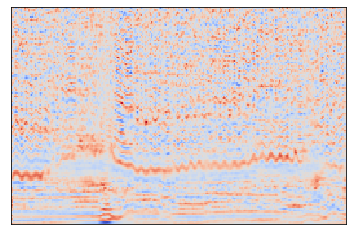

In [ ]:
librosa.display.specshow(mfccs_sk, sr=sample_rate)

In [ ]:
audio_path = data['path'][1350]
print(audio_path)
y,sr = librosa.load(audio_path)
S = np.abs(librosa.stft(y))



/content/gdrive/My Drive/UpworkNotebooks/Opera Files/All_Data/males_500/baritone/baritone_lyric/Simon_Boccanegra_-_Prologue_-_Che_dicesti_(Paolo,_Pietro,_Simone)-D_q1Ft6fvZg_5.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


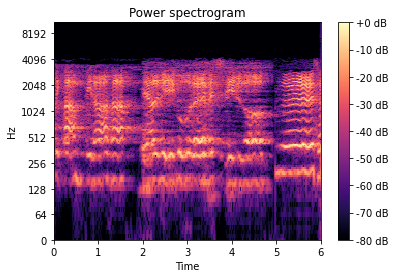

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)


ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")